In [1]:
import pandas as pd
import sys
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

In [2]:
# Load from CSV file
data_filename = "../Big-5-Data/data.csv"
main_df = pd.read_csv(data_filename, sep='\t')
main_df.head()

,race,age,engnat,gender,hand,source,country,E1,E2,E3,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,3,53,1,1,1,1,US,4,2,5,...,4,1,3,1,5,1,4,2,5,5
1,13,46,1,2,1,1,US,2,2,3,...,3,3,3,3,2,3,3,1,3,2
2,1,14,2,2,1,1,PK,5,1,1,...,4,5,5,1,5,1,5,5,5,5
3,3,19,2,2,1,1,RO,2,5,2,...,4,3,5,2,4,2,5,2,5,5
4,11,25,2,2,1,2,US,3,1,3,...,3,1,1,1,3,1,3,1,5,3


In [3]:
# Copy the personality data.
big5_df = main_df.iloc[:, 7:].copy()
# Average 10 extraversion answers, neuroticism answers, etc. and put averages into a new table.
big5_df = big5_df.groupby(np.arange(len(big5_df.columns))//10, axis=1).mean()
# Rename columns that got lost in averaging
big5_df.columns = ['E', 'N', 'A', 'C', 'O']
# We now have averages of the big 5 personality traits and appropriate scores for each.
big5_df.head()

,E,N,A,C,O
0,3.2,1.9,3.2,3.1,3.1
1,2.8,2.9,3.1,2.8,2.6
2,2.9,4.6,3.8,3.3,4.1
3,3.6,4.3,3.7,3.4,3.7
4,2.6,3.2,4.0,2.6,2.2


In [4]:
from visualization import generateScatterPlot
# Let's use a custom method from visualization.py to the 5 features against each other (opens in a new tab). 
#  Notice any patterns? Darkness of blue is represented by openness and size of the marker is represented 
#  by consciousness. Note we're just using 150 samples for a clean view.
generateScatterPlot("5D-Big-5-Plot.html", big5_df, 150, 1.5)

In [5]:
# We can use a dendogram to figure out what number of clusters best represents the data.
# plt.figure(figsize=(10, 7))
# plt.title("Cluster Dendograms")
# dend = shc.dendrogram(shc.linkage(big5_df, method='ward'))

In [6]:
# plt.show()
# The plot display takes a while to run (and is tedious to reproduce more than once without a lot of computing power),
#  so I'll just include an image here for you: https://imgur.com/a/Hdeea94.
# As we can tell from the dendogram, the longest length lines without a break, and thus number of clusters with
#  the greatest difference between them, occurs at 2 clusters. 5 different clusters would be a poor amount to choose because bridged differences
#  are not as high (and thus the clusters are not as distinct). We want to have more than 2 groups (not as fun!), so
#  we'll try having 4 different clusters.

In [7]:
# We'll use the KMeans algorithm for clustering. It will find "cluster centers" where we might find higher densities
#  of data points. Those high densities might point towards personality "types", where people of similar traits
#  can be found in number.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4)
kmeans.fit(big5_df)
print(kmeans.cluster_centers_)

[[2.94021649 3.39631557 3.06378018 2.92805995 3.0636761 ]
 [3.18235854 2.95705849 3.29742808 3.32267098 3.47250905]
 [3.0499625  2.28773903 3.09415073 2.99820022 3.2355643 ]
 [3.13234072 3.92285319 3.38506464 3.39542936 3.49374423]]


In [8]:
# Now that we've got our cluster centers, we're going to transform them to make them a bit more readable. The 
#  StandardScalar is usually used for processing data before supervised learning, but here it works well to 
#  help us visualize and understand the data better. It transforms our data such that the mean for all 4 points
#  is zero and the the variance is 1. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(kmeans.cluster_centers_)
transformed_cluster_centers = scaler.transform(kmeans.cluster_centers_)
# Put into a dataframe for readability and plotting.
class_names = ["Class 1", "Class 2", "Class 3", "Class 4"]
cluster_centers_df = pd.DataFrame(data=transformed_cluster_centers, index=class_names, columns=big5_df.columns)
print(cluster_centers_df)


                E         N         A         C         O
Class 1 -1.483886  0.425781 -1.082466 -1.158439 -1.422520
Class 2  1.158048 -0.306729  0.645978  0.803250  0.878941
Class 3 -0.286482 -1.422894 -0.857795 -0.809758 -0.454902
Class 4  0.612320  1.303841  1.294283  1.164947  0.998481


In [9]:
# Here's a 3d scatter plot of the the categories.
generateScatterPlot("5D-Big-5-Categories.html", cluster_centers_df, 4, 40)

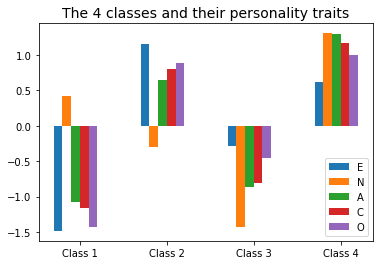

In [12]:
# But I thought a bar chart would be more readable. Stay with me here, this visualization took some effort.
class_based_data = transformed_cluster_centers.transpose()
width = 0.1
num_classes = len(class_based_data[0])
num_personality_types = 5
plt.bar(np.arange(4), class_based_data[0], width=width)
for x in range(1,num_personality_types):
    plt.bar(np.arange(4) + width*x, class_based_data[x], width=width)
class_names_pos = np.arange(num_classes) + 0.25
plt.xticks(class_names_pos, class_names)
plt.title('The 4 classes and their personality traits',fontsize=14)
plt.legend(big5_df.columns, loc=4)
plt.show()

In [11]:
# How interesting! We can now see we've got 4 different kinds of people. The first one is low on all personality
#  trait scores except for Nueroiticism (maybe not the luckiest bunch!).Then, in class 2, we've got people who are 
#  generally very extraverted, not too neutoritic, and above average in the rest. And in class 3, which is especially 
#  low in neuroticism (yay for them!) and low in the rest (although around average extraversion). Then we've got a 
#  person who's high on all fronts, except maybe not that extraverted.
# I'm a little bit worried that the classes seem to be based on simply whether a person is high in all the traits,
#  or low. The clusters aren't telling us much if they're just repeating what the personality scores already say!

In [14]:
# Because of this concern, we'll try using a different clustering model.
# Clusters start small, and then become bigger and bigger as they're merged together. The algorithm stops when the 
#  target number of clusters is reached. This is how the dendogram was formed, with two branches coming together when
#  two clusters are merged. 4 is our target number again.
from sklearn.cluster import AgglomerativeClustering
aggl_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster_assignments = aggl_cluster.fit_predict(big5_df)

In [15]:
# We now have group assignments for each of the samples! This takes just ~20 seconds to run on my local machine.
print(cluster_assignments)

[0 2 1 ... 1 1 3]


In [34]:
# I'm interested in viewing what each cluster (potential personality type) looks like, but agglomerative clustering 
#  doesn't give us cluster centers like KMeans does. So let's calculate our own, using the average personality traits
#  for each grouping.
num_clusters = 4
num_personality_traits = 5
cluster_centers = []
# Iterate through each cluster group.
for cluster_num in range(0, num_clusters):
    cluster_sum = [0,0,0,0,0]
    num_samples_in_cluster = 0
    for sample_index in range(0, len(big5_df)):
        if(cluster_num == cluster_assignments[sample_index]):
            sample_arr = np.array(big5_df.iloc[sample_index]) 
            # Store the total trait scores, tracking the number of samples as we go along.
            cluster_sum = [cluster_sum[x] + sample_arr[x] for x in range(0, num_personality_traits)]
            num_samples_in_cluster += 1
    # Find the average by dividing the totals by the number of samples.
    cluster_averages = [cluster_sum[x]/num_samples_in_cluster for x in range(0, num_personality_traits)]
    cluster_centers.append(cluster_averages)
print(cluster_centers)

[[3.0808243943593983, 2.4879595034349706, 3.1249969868627288, 3.059648065565869, 3.2890803905025794], [3.0320803295571555, 3.936251287332656, 3.3599382080329527, 3.3018537590113395, 3.4488928939237993], [2.9059618633840145, 3.3410813420226932, 3.099734491914062, 2.97197682838522, 3.1161718561428873], [3.325243004418266, 3.3169366715758577, 3.3503976435935177, 3.4419145802650957, 3.4589690721649498]]


In [36]:
# Lovely! Now let's do the same transformation we did for KMeans...
scaler2 = StandardScaler()
scaler2.fit(cluster_centers)
transformed_cluster_centers2 = scaler.transform(cluster_centers)
# Put into a dataframe for readability and plotting.
class_names = ["Class 1", "Class 2", "Class 3", "Class 4"]
cluster_centers_df2 = pd.DataFrame(data=transformed_cluster_centers2, index=class_names, columns=big5_df.columns)
print(cluster_centers_df2)

                E         N         A         C         O
Class 1  0.050242 -1.089004 -0.629606 -0.504289 -0.153642
Class 2 -0.481589  1.326184  1.108406  0.699764  0.745998
Class 3 -1.857627  0.333672 -0.816489 -0.940120 -1.127003
Class 4  2.717014  0.293408  1.037828  1.396034  0.802720


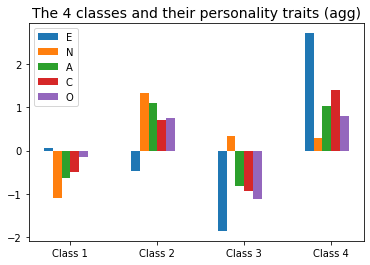

In [38]:
# And a new chart... Sorry for the repeititon (most of this is copy-and-pasted.)
class_based_data2 = transformed_cluster_centers2.transpose()
width = 0.1
num_classes = len(class_based_data2[0])
plt.bar(np.arange(4), class_based_data2[0], width=width)
for x in range(1 ,num_personality_traits):
    plt.bar(np.arange(4) + width*x, class_based_data2[x], width=width)
class_names_pos2 = np.arange(num_classes) + 0.25
plt.xticks(class_names_pos2, class_names)
plt.title('The 4 classes and their personality traits (agg)',fontsize=14)
plt.legend(big5_df.columns, loc="best")
plt.show()

In [ ]:
# Hmm! Much more variety, and thus much more interetesting! 
# What stands out to me is the way Agreeableness, Consciousness, and Opennes tend to flow together in the classes,
#  just like with the KMeans algorithm. This suggests Extraversion and Neuroticism form the main differentiators 
#  between groupings. This makes me want to look at the correlations between the traits, to see whether extraversion
#  and neuroticism are the most independent variables. I have a feeling we'd see lower correlations between E/N and 
#  each of the other 4 variables, than for A/C/O and each of the other variables. 